# Определение перспективного тарифа для телеком-компании

**Цель**
Проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Задача**
Сделать предварительный анализ тарифов на небольшой выборке клиентов (данные 500 пользователей «Мегалайна»): кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

**ИНФОРМАЦИЯ НА ВХОДЕ**

**Описание тарифов**

***Тариф «Смарт»***
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
     - минута разговора: 3 рубля
     - сообщение: 3 рубля
     - 1 Гб интернет-трафика: 200 рублей

***Тариф «Ультра»***
 - Ежемесячная плата: 1950 рублей
 - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
 - Стоимость услуг сверх тарифного пакета:
     - минута разговора: 1 рубль
     - сообщение: 1 рубль
     - 1 Гб интернет-трафика: 150 рублей
     
**Описание данных**

***Таблица users*** (информация о пользователях):

user_id — уникальный идентификатор пользователя

first_name — имя пользователя

last_name — фамилия пользователя

age — возраст пользователя (годы)

reg_date — дата подключения тарифа (день, месяц, год)

churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

city — город проживания пользователя

tariff — название тарифного плана

***Таблица calls*** (информация о звонках):

id — уникальный номер звонка

call_date — дата звонка

duration — длительность звонка в минутах

user_id — идентификатор пользователя, сделавшего звонок

***Таблица messages*** (информация о сообщениях):

id — уникальный номер сообщения

message_date — дата сообщения

user_id — идентификатор пользователя, отправившего сообщение

***Таблица internet*** (информация об интернет-сессиях):

id — уникальный номер сессии

mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)

session_date — дата интернет-сессии

user_id — идентификатор пользователя

***Таблица tariffs*** (информация о тарифах):

tariff_name — название тарифа

rub_monthly_fee — ежемесячная абонентская плата в рублях

minutes_included — количество минут разговора в месяц, включённых в абонентскую плату

messages_included — количество сообщений в месяц, включённых в абонентскую плату

mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

rub_per_message — стоимость отправки сообщения сверх тарифного пакета

rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Предобработка данных

### Общая информация
Импортируем необходимые для работы библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

Импортируем данные

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Рассмотрим общую информацию по всем данным сразу

In [3]:
for data in [calls, internet, messages, tariffs, users]: 
    print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns

In [4]:
for data in [calls, internet, messages, tariffs, users]: 
    display(data.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


 Датасет содержит данные по 500 клиентам, потребуется заменить тип данных у столбцов с датой и временем, а также округлить значения минут разговора и мегабайт использованного трафика в большую сторону, так как тарифы считаются по минутам и мегабайтам.

Кроме того, после объединения данных (сводная таблица по звонкам, по сообщениям и интернет-трафику) возникнут пропущенные значения (клиент мог в каком-то месяце не писать сообщений, но звонить и использовать интернет), которые также нужно будет заменить на нули.

### Замена типов данных
Заменим тип данных в датафреймах, обозначающих дату (str на datetime):

In [5]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

### Исправление ошибок
Рассмотрим **звонки** с нулевой длительностью: 

In [6]:
print('Количество звонков с нулевой длительностью =', calls.loc[calls['duration'] == 0, 'duration'].value_counts()[0])

Количество звонков с нулевой длительностью = 39613


Нулевых звонков достаточно много, чтобы не обратить на них внимание. Рассмотрим их в разрезе месяца. Добавим в датафрейм звонков столбец с месяцем и построим график зависимости количества звонков с нулевой длительностью от общего числа помесячно

In [7]:
calls['month'] = calls['call_date'].dt.month
calls

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


In [8]:
calls.loc[calls['duration'] == 0, 'zero_count'] = 1
zero_calls = calls.pivot_table(index='month', values=['id', 'zero_count'], aggfunc='count')
zero_calls

,id,zero_count
month,,
1,1476,312
2,3328,623
3,6687,1304
4,9272,1768
5,12647,2531
6,14716,2883
7,18298,3518
8,21488,4231
9,24061,4615


In [9]:
zero_calls['zero_ratio'] = round(zero_calls['zero_count'] / zero_calls['id'], 4)
zero_calls

,id,zero_count,zero_ratio
month,,,
1,1476,312,0.2114
2,3328,623,0.1872
3,6687,1304,0.1950
4,9272,1768,0.1907
5,12647,2531,0.2001
6,14716,2883,0.1959
7,18298,3518,0.1923
8,21488,4231,0.1969
9,24061,4615,0.1918


Построим диаграмму рассеяния

Text(14.505633680555562, 0.5, 'Число нулевых звонков по месям')

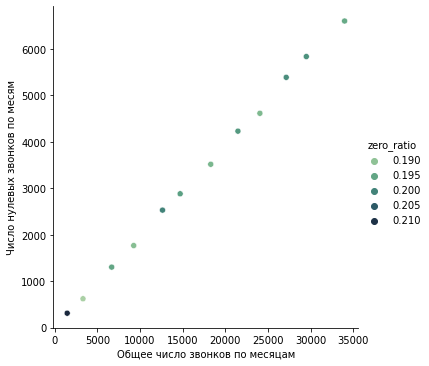

In [10]:
import seaborn as sns
sns.relplot(x='id', y='zero_count', hue="zero_ratio", palette="ch:r=-.5,l=.75",  data=zero_calls)
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число нулевых звонков по месям')

Очевидно, имеем устойчивое и систематическое поведение доли пропущенных звонков, недозваниваются ежемесячно примерно одинаково. Заменим нулевые звонки на 1, а в силу поминутного характера тарифа все ненулевые округлим в большую сторону.

In [11]:
calls.loc[calls['duration'] == 0, 'duration'] = 1

In [12]:
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls['duration']

0          1
1          1
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int64

Аналогично обработаем **интернет-сессии** с нулевым объемом потраченного трафика: 

In [13]:
internet['month'] = internet['session_date'].dt.month

In [14]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [15]:
internet['mb_used'].sum()

55305267.73

По интернет-сессиям суммируем весь трафик за месяц по пользователям, переведем мегабайты в гигабайты и округлим в большую сторону

In [16]:
internet.groupby(['month', 'user_id'])['mb_used'].sum().reset_index()

,month,user_id,mb_used
0,1,1005,2727.97
1,1,1032,24127.69
2,1,1045,2346.71
3,1,1055,17090.88
4,1,1071,15604.34
...,...,...,...
3198,12,1494,17621.21
3199,12,1495,23426.76
3200,12,1496,20736.15
3201,12,1497,19918.60


In [17]:
internet

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499,10
149392,149392,1499_153,490.13,2018-12-14,1499,12
149393,149393,1499_154,0.00,2018-10-27,1499,10
149394,149394,1499_155,1246.32,2018-11-26,1499,11


## Расчеты

Для каждого пользователя нам необходимо расчитать по месяцам:
 - количество сделанных звонков и израсходованных минут разговора
 - количество отправленных сообщений 
 - объем израсходованного интернет-трафика

In [18]:
users['unique_name'] = users['first_name'] + users['last_name'] + users['city'] 
users['unique_name']

0         РафаилВерещагинКраснодар
1                   ИванЕжовМосква
2      ЕвгенийАбрамовичСтерлитамак
3              БеллаБеляковаМосква
4       ТатьянаАвдеенкоНовокузнецк
                  ...             
495          АвксентийФокинИркутск
496            ТрифонБлохинВологда
497        КаролинаАгееваЧелябинск
498     ВсеволодАкимчинВладикавказ
499            ГекторКорниловПермь
Name: unique_name, Length: 500, dtype: object

Добавим в датафрейм с сообщениями столбец с месяцем и сделаем сводные таблицы по звонкам, сообщениям и трафику:

In [19]:
messages['month'] = messages['message_date'].dt.month
messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


In [20]:
calls_t = calls.merge(users, on='user_id', how='inner')
calls_grouped = calls_t.pivot_table(values=['unique_name', 'duration'], index=['user_id', 'month'], aggfunc={'unique_name': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']

Сообщения:

In [21]:
messages_t = messages.merge(users, on='user_id', how='inner')
messages_grouped = messages_t.pivot_table(values='unique_name',  index=['user_id', 'month'], aggfunc={'unique_name': 'count'})
messages_grouped.columns = ['messages']

Интернет-трафик:

In [22]:
internet_t = internet.merge(users, on='user_id', how='inner')
internet_grouped = internet_t.pivot_table(values='mb_used', index=['user_id', 'month'], aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['mb_used']

Объединим эти сводные таблички в одну:

In [23]:
from functools import reduce
data_pivot = [calls_grouped, messages_grouped, internet_grouped]
grouped_data = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), data_pivot)
grouped_data.head(15)

duration  calls  messages   mb_used
user_id month                                     
1000    5         164.0   22.0      22.0   2253.49
        6         187.0   43.0      60.0  23233.77
        7         346.0   47.0      75.0  14003.64
        8         418.0   52.0      81.0  14055.93
        9         478.0   58.0      57.0  14568.91
        10        363.0   57.0      73.0  14702.49
        11        344.0   43.0      58.0  14756.47
        12        341.0   46.0      70.0   9817.61
1001    11        444.0   59.0       NaN  18429.34
        12        430.0   63.0       NaN  14036.66
1002    6         118.0   15.0       4.0  10856.82
        7         219.0   26.0      11.0  17580.10
        8         294.0   42.0      13.0  20319.26
        9         217.0   36.0       4.0  16691.08
        10        221.0   33.0      10.0  13888.25

In [24]:
internet['mb_used'].sum() # трафик в Мб до перевода в Гб и округления 

55305267.73

Количество сделанных звонков и израсходованных минут разговора, отправленных сообщений и объем израсходованного интернет-трафика по месяцам для каждого пользователя посчитан. 

Теперь посчитаем помесячную выручку для каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану). Пропущенные значения в столбцах duration, messages и mb_used заменим на нули. Присвоим каждому пользователю используемый им тариф.

In [25]:
grouped_data.loc[grouped_data['duration'].isna(), 'duration'] = 0
grouped_data.loc[grouped_data['messages'].isna(), 'messages'] = 0
grouped_data.loc[grouped_data['mb_used'].isna(), 'mb_used'] = 0

In [26]:
for user in grouped_data.index:
    grouped_data.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

In [27]:
grouped_data

duration  calls  messages   mb_used tariff
user_id month                                            
1000    5         164.0   22.0      22.0   2253.49  ultra
        6         187.0   43.0      60.0  23233.77  ultra
        7         346.0   47.0      75.0  14003.64  ultra
        8         418.0   52.0      81.0  14055.93  ultra
        9         478.0   58.0      57.0  14568.91  ultra
...                 ...    ...       ...       ...    ...
1489    9           0.0    NaN      32.0  17206.30  smart
        10          0.0    NaN      21.0  19559.44  smart
        11          0.0    NaN      20.0  17491.56  smart
        12          0.0    NaN      35.0  17322.51  smart
1476    4           0.0    NaN       0.0    530.78  ultra

[3214 rows x 5 columns]

Для расчета помесячной выручки с каждого пользователя пропишем функцию:

In [28]:
def month_revenue(row):
    messages = row['messages']
    mb_used = row['mb_used']
    calls = row['calls']
    duration = row['duration']
    tariff = row['tariff']
    
    if tariff == 'smart':
        required_duration = duration - tariffs.loc[0, 'minutes_included']
        required_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        required_messages = messages - tariffs.loc[0, 'messages_included']
        
        if required_duration < 0: required_duration = 0
        if required_mb < 0: required_mb = 0
        if required_messages < 0: required_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * required_messages + 
                   (tariffs.loc[1, 'rub_per_gb'] / 1024)  * required_mb + 
                   tariffs.loc[0, 'rub_per_minute'] * required_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        required_duration = duration - tariffs.loc[1, 'minutes_included']
        required_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        required_messages = messages - tariffs.loc[1, 'messages_included']
        
        if required_duration < 0: required_duration = 0
        if required_mb < 0: required_mb = 0
        if required_messages < 0: required_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * required_messages + 
                   (tariffs.loc[1, 'rub_per_gb'] / 1024) * required_mb + 
                   tariffs.loc[1, 'rub_per_minute'] * required_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )   
    

In [29]:
grouped_data['revenue'] = grouped_data.apply(month_revenue, axis=1)
grouped_data.head(15)

duration  calls  messages   mb_used tariff      revenue
user_id month                                                         
1000    5         164.0   22.0      22.0   2253.49  ultra  1950.000000
        6         187.0   43.0      60.0  23233.77  ultra  1950.000000
        7         346.0   47.0      75.0  14003.64  ultra  1950.000000
        8         418.0   52.0      81.0  14055.93  ultra  1950.000000
        9         478.0   58.0      57.0  14568.91  ultra  1950.000000
        10        363.0   57.0      73.0  14702.49  ultra  1950.000000
        11        344.0   43.0      58.0  14756.47  ultra  1950.000000
        12        341.0   46.0      70.0   9817.61  ultra  1950.000000
1001    11        444.0   59.0       0.0  18429.34  smart   999.610352
        12        430.0   63.0       0.0  14036.66  smart   550.000000
1002    6         118.0   15.0       4.0  10856.82  smart   550.000000
        7         219.0   26.0      11.0  17580.10  smart   875.209961
        8         294.0   42.0      13.0  20319.26  smart  1276.454102
        9         217.0   36.0       4.0  16691.08  smart   744.982422
        10        221.0   33.0      10.0  13888.25  smart   550.000000

In [30]:
grouped_data['gb_used'] = grouped_data['mb_used']/1024 
grouped_data['gb_used'] = np.ceil(grouped_data['gb_used']).astype('int')
grouped_data['gb_used'].sum()

55599

Помесячную выручку с каждого пользователя рассчитали

## Анализ данных

Определим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц

In [31]:
grouped_data

duration  calls  messages   mb_used tariff      revenue  \
user_id month                                                            
1000    5         164.0   22.0      22.0   2253.49  ultra  1950.000000   
        6         187.0   43.0      60.0  23233.77  ultra  1950.000000   
        7         346.0   47.0      75.0  14003.64  ultra  1950.000000   
        8         418.0   52.0      81.0  14055.93  ultra  1950.000000   
        9         478.0   58.0      57.0  14568.91  ultra  1950.000000   
...                 ...    ...       ...       ...    ...          ...   
1489    9           0.0    NaN      32.0  17206.30  smart   820.454102   
        10          0.0    NaN      21.0  19559.44  smart  1165.152344   
        11          0.0    NaN      20.0  17491.56  smart   862.240234   
        12          0.0    NaN      35.0  17322.51  smart   837.477051   
1476    4           0.0    NaN       0.0    530.78  ultra  1950.000000   

               gb_used  
user_id month           
1000    5            3  
        6           23  
        7           14  
        8           14  
        9           15  
...                ...  
1489    9           17  
        10          20  
        11          18  
        12          17  
1476    4            1  

[3214 rows x 7 columns]

Расчитаем общие показатели всех клиентов по месяцам по обоим тарифам

In [32]:
all_clients_month = grouped_data.groupby(['tariff', 'month'])['duration', 'calls', 'messages', 'gb_used', 'revenue'].sum().reset_index()
all_clients_month.head(12)

/tmp/ipykernel_37/599676727.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_clients_month = grouped_data.groupby(['tariff', 'month'])['duration', 'calls', 'messages', 'gb_used', 'revenue'].sum().reset_index()


,tariff,month,duration,calls,messages,gb_used,revenue
0,smart,1,7128.0,941.0,620.0,297,22692.986816
1,smart,2,17766.0,2331.0,1397.0,687,44074.780762
2,smart,3,30841.0,4183.0,2453.0,1173,78380.606445
3,smart,4,42224.0,5747.0,3443.0,1526,96606.490234
4,smart,5,56175.0,7789.0,4762.0,2243,145714.905762
5,smart,6,66699.0,9110.0,5478.0,2616,170232.199707
6,smart,7,84277.0,11402.0,6784.0,3191,212699.188477
7,smart,8,101800.0,13860.0,7905.0,3933,265843.228516
8,smart,9,114421.0,15482.0,8746.0,4262,283103.771973
9,smart,10,128859.0,17629.0,9927.0,4963,343803.604980


Изучим поподробнее каждый тариф, разобьем данные по каждому тарифу

In [33]:
all_clients_month_smart = all_clients_month.query('tariff=="smart"').reset_index(drop=True)
all_clients_month_smart

,tariff,month,duration,calls,messages,gb_used,revenue
0,smart,1,7128.0,941.0,620.0,297,22692.986816
1,smart,2,17766.0,2331.0,1397.0,687,44074.780762
2,smart,3,30841.0,4183.0,2453.0,1173,78380.606445
3,smart,4,42224.0,5747.0,3443.0,1526,96606.490234
4,smart,5,56175.0,7789.0,4762.0,2243,145714.905762
5,smart,6,66699.0,9110.0,5478.0,2616,170232.199707
6,smart,7,84277.0,11402.0,6784.0,3191,212699.188477
7,smart,8,101800.0,13860.0,7905.0,3933,265843.228516
8,smart,9,114421.0,15482.0,8746.0,4262,283103.771973
9,smart,10,128859.0,17629.0,9927.0,4963,343803.604980


In [34]:
all_clients_month_ultra = all_clients_month.query('tariff=="ultra"').reset_index(drop=True)
all_clients_month_ultra

,tariff,month,duration,calls,messages,gb_used,revenue
0,ultra,1,3968.0,535.0,304.0,119,17550.000000
1,ultra,2,7312.0,997.0,527.0,288,47343.958008
2,ultra,3,18614.0,2504.0,1195.0,653,74130.880371
3,ultra,4,25854.0,3525.0,1736.0,933,109725.912598
4,ultra,5,35166.0,4858.0,2536.0,1298,137649.963867
5,ultra,6,41364.0,5606.0,3505.0,1591,170649.014648
6,ultra,7,50987.0,6896.0,4536.0,1866,191806.013672
7,ultra,8,56129.0,7628.0,5183.0,2097,221531.037598
8,ultra,9,63669.0,8579.0,6013.0,2213,231514.627441
9,ultra,10,70458.0,9517.0,7187.0,2468,252922.224609


Попробуем визуализировать на одном графике по каждому параметру

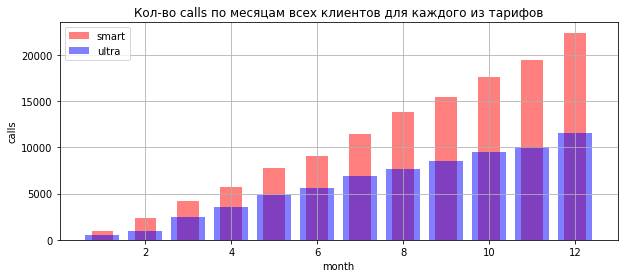

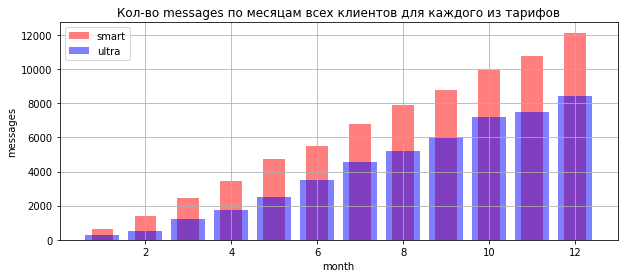

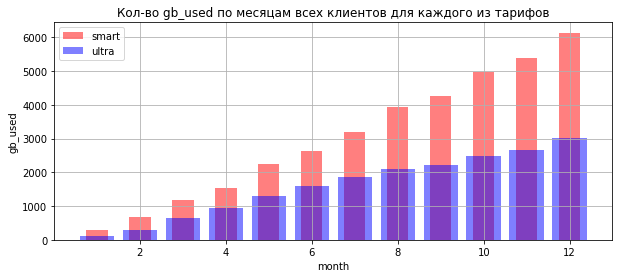

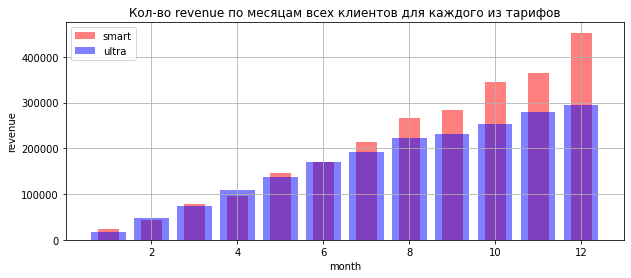

In [35]:
for i in ['calls', 'messages', 'gb_used','revenue']:
    plt.figure(figsize=(10, 4))
    plt.bar(all_clients_month_smart['month'], all_clients_month_smart[i], label='smart', color='r', alpha=0.5, width=0.5)
    plt.bar(all_clients_month_ultra['month'], all_clients_month_ultra[i], label='ultra', color='b', alpha=0.5)
    plt.xlabel('month')
    plt.ylabel(i)
    plt.title(f'Кол-во {i} по месяцам всех клиентов для каждого из тарифов')
    plt.legend()
    plt.grid()
    plt.show()
    

Для конкретных выводов определимся с количеством пользователей каждого из тарифов

In [36]:
users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64


    
- Из графиков видно, что общий расход минут,сообщений и трафика всех абонентов тарифа Смарт стабильно выше, чем Ультра, но и количество абонентов у более дешевого тарифа в 2,4 раза больше. 
    
- По выручке - абоненты Смарт в первой половине года тратят больше в месяцы, в которых есть праздничные дни (январь, март, май), во второй половине года стабильно с каждым месяцем приносят выручки все больше и больше вплоть до декабря, где выручка уже почти в 1,6 раза больше, чем от тарифа Ультра. Выручка тарифа Ультра растет стабильно в течение всего года.
    
- Гистограммы постоянно возрастают от меcяца к месяцу. Это может свидетельствовать о притоке новых абонентов ежемесячно. Поэтому логично будет посчитать усредненные показатели расхода на одного абонента за каждый месяц и уже тогда сравнить тарифы.

In [37]:
grouped_data[['duration','calls', 'messages', 'gb_used','revenue']].describe()

,duration,calls,messages,gb_used,revenue
count,3214.000000,3174.000000,3214.000000,3214.000000,3214.000000
mean,463.570006,63.833333,38.281269,17.299004,1403.092603
std,247.918544,32.678036,36.148326,7.400584,712.396542
min,0.000000,1.000000,0.000000,0.000000,550.000000
25%,291.000000,41.000000,9.000000,13.000000,699.023315
50%,456.000000,63.000000,30.000000,17.000000,1390.038818
75%,605.000000,83.000000,57.000000,21.000000,1950.000000
max,1727.000000,244.000000,224.000000,49.000000,5621.331543


Для вычисления усредненных значений можно использовать и среднее и медиану, по условию задания нужно найти средние значения. 
Сгруппируем и создадим новую таблицу с общими данными по тарифам, затем изучим ее данные в разрезе каждого тарифа

In [38]:
mean_data = grouped_data.groupby(['tariff', 'month'])['duration','calls', 'messages', 'gb_used','revenue'].mean().reset_index()
mean_data

/tmp/ipykernel_37/712126112.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_data = grouped_data.groupby(['tariff', 'month'])['duration','calls', 'messages', 'gb_used','revenue'].mean().reset_index()


,tariff,month,duration,calls,messages,gb_used,revenue
0,smart,1,209.647059,27.676471,18.235294,8.735294,667.440789
1,smart,2,306.310345,40.189655,24.086207,11.844828,759.910013
2,smart,3,400.532468,54.324675,31.857143,15.233766,1017.929954
3,smart,4,377.000000,51.312500,30.741071,13.625000,862.557949
4,smart,5,398.404255,55.241135,33.773050,15.907801,1033.439048
5,smart,6,406.701220,55.889571,33.402439,15.951220,1038.001218
6,smart,7,419.288557,56.726368,33.751244,15.875622,1058.204918
7,smart,8,433.191489,59.230769,33.638298,16.736170,1131.247781
8,smart,9,440.080769,59.776062,33.638462,16.392308,1088.860661
9,smart,10,438.295918,60.167235,33.765306,16.880952,1169.400017


In [39]:
smart = mean_data.query('tariff=="smart"')
ultra = mean_data.query('tariff=="ultra"')

In [40]:
print('Средние месячные значения абонента в течение 2018 года')
for i in ['duration','calls', 'messages', 'gb_used','revenue']:
    print(f'{i}: smart = {round(smart[i].mean())} / ultra = {round(ultra[i].mean())}')

Средние месячные значения абонента в течение 2018 года
duration: smart = 397 / ultra = 509
calls: smart = 54 / ultra = 71
messages: smart = 31 / ultra = 44
gb_used: smart = 15 / ultra = 18
revenue: smart = 1027 / ultra = 2038



На данном этапе исследований мы видим, что пользователи обоих тарифов больше всего используют интернет-трафик, сообщения не являются популярной услугой, звонки популярны в месяцы с праздничными днями.
Среднемесячная выручка тарифа смарт составляет 1027 рублей и меньше выручки более дорогого тарифа в ~2 раза
    

**Тариф «Смарт»**

- ежемесячная плата: 1027/550 рублей (превышение на 477 рублей или 86,7%)
- минут разговора: 397/500 (используется 79,4% пакета услуг) 
- сообщений: 31/50 (используется 62% пакетных услуг)
- интернет-трафика: 15/15 Гб (используется 100% пакетных услуг)
При общем перерасходе ежемесячной платы, скорее всего доплачивается за 1 Гб интернет-трафика: 200 рублей (при среднем пороговом в 15 Гб)

**Тариф «Ультра»**
- ежемесячная плата: 2038/1950 рублей (превышение на 88 рублей или 4,5%)
- минут разговора: 509/3000 (используется 16,9% пакета услуг) 
- сообщений: 44/1000 (используется 4,4% пакетных услуг)
- интернет-трафика: 18/30 Гб (используется 60% пакетных услуг)
Здесь аналогично при небольшом общем перерасходе ежемесячной платы, скорее всего доплачивается за 1 Гб интернет-трафика: 150 рублей (при среднем пороговом в 30 Гб), в среднем пользователи Ультра укладываются в рамки своего тарифного плана.

Посчитаем среднее количество, дисперсию и стандартное отклонение

In [41]:
mean_data

,tariff,month,duration,calls,messages,gb_used,revenue
0,smart,1,209.647059,27.676471,18.235294,8.735294,667.440789
1,smart,2,306.310345,40.189655,24.086207,11.844828,759.910013
2,smart,3,400.532468,54.324675,31.857143,15.233766,1017.929954
3,smart,4,377.000000,51.312500,30.741071,13.625000,862.557949
4,smart,5,398.404255,55.241135,33.773050,15.907801,1033.439048
5,smart,6,406.701220,55.889571,33.402439,15.951220,1038.001218
6,smart,7,419.288557,56.726368,33.751244,15.875622,1058.204918
7,smart,8,433.191489,59.230769,33.638298,16.736170,1131.247781
8,smart,9,440.080769,59.776062,33.638462,16.392308,1088.860661
9,smart,10,438.295918,60.167235,33.765306,16.880952,1169.400017


In [42]:
mean_data.dropna(subset=['duration'], inplace=True)
descriptive_statistics = mean_data.pivot_table(index=['tariff'], values=['duration', 'gb_used', 'messages'], aggfunc=['mean', 'var', 'std'])
descriptive_statistics

mean                                var                        \
          duration    gb_used   messages     duration   gb_used    messages   
tariff                                                                        
smart   397.374228  15.198728  31.413211  5516.161324  6.900985   26.044827   
ultra   509.356551  18.258937  43.714983  6329.465189  8.535354  151.793988   

              std                       
         duration   gb_used   messages  
tariff                                  
smart   74.270865  2.626973   5.103413  
ultra   79.557936  2.921533  12.320470

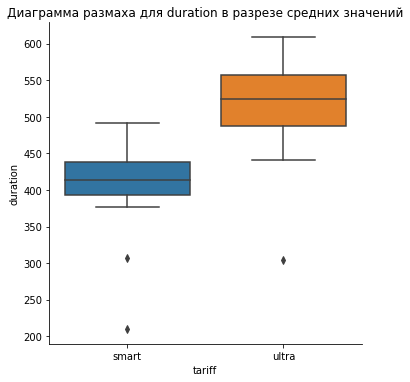

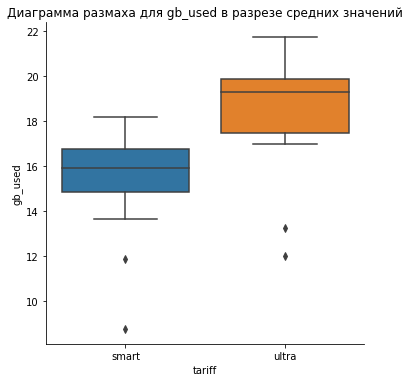

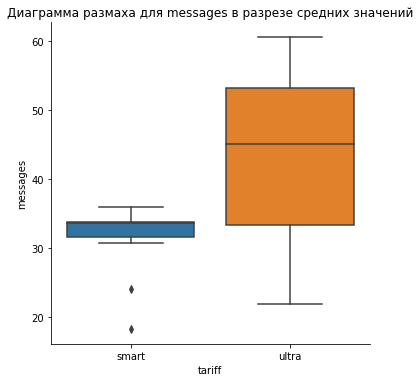

In [43]:
for column in ['duration', 'gb_used', 'messages']:    
    sns.catplot(x="tariff", y=column, kind="box", data=mean_data)
    plt.title(f'Диаграмма размаха для {column} в разрезе средних значений')
    

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


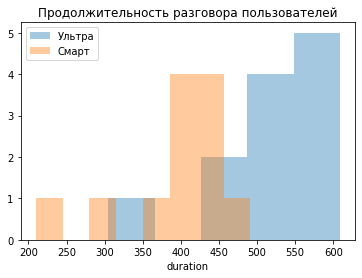

In [44]:
for tariff in ['ultra', 'smart']:
    sns.distplot(mean_data.query('tariff == @tariff')['duration'], kde=False, label=tariff)
    plt.legend(['Ультра', 'Смарт'])
    plt.title(f'Продолжительность разговора пользователей')

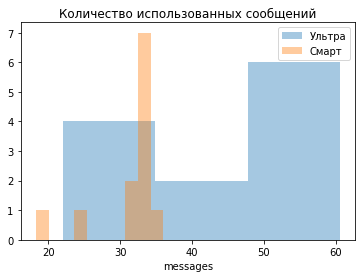

In [45]:
for tariff in ['ultra', 'smart']:
    sns.distplot(mean_data.query('tariff == @tariff')['messages'], kde=False, label=tariff)
    plt.legend(['Ультра', 'Смарт'])
    plt.title(f'Количество использованных сообщений')

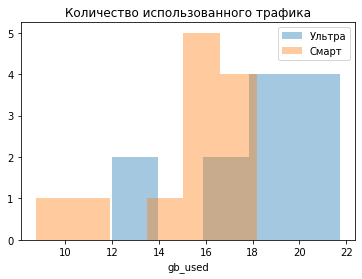

In [46]:
for tariff in ['ultra', 'smart']:
    sns.distplot(mean_data.query('tariff == @tariff')['gb_used'], kde=False)
    plt.legend(['Ультра', 'Смарт'])
    plt.title(f'Количество использованного трафика')

In [47]:
descriptive_statistics

mean                                var                        \
          duration    gb_used   messages     duration   gb_used    messages   
tariff                                                                        
smart   397.374228  15.198728  31.413211  5516.161324  6.900985   26.044827   
ultra   509.356551  18.258937  43.714983  6329.465189  8.535354  151.793988   

              std                       
         duration   gb_used   messages  
tariff                                  
smart   74.270865  2.626973   5.103413  
ultra   79.557936  2.921533  12.320470

In [48]:
mean_data.pivot_table(index='tariff', values='revenue', aggfunc='mean')

,revenue
tariff,
smart,1027.042710
ultra,2038.349917



    
**Выводы**

Видим, что по всем исследуемым параметрам (минуты разговора, количество отправленных сообщений и объем потраченного трафика) тариф «Ультра» имеет большую дисперсию по сравнению с тарифом "Смарт", хотя медианы по вышеперечисленным признакам хоть также смещены в большую сторону, но достаточно близки (исключение составляют лишь сообщения- здесь медианная разница ярче выражена - мало кто во времена мессенджеров использует пакет сообщений "на всю катушку") Также заметим, что выбросов в рамках более дешевого тарифа существенно больше.

Поведение пользователей тарифа "Ультра" более разнообразное с точки зрения потребления телекоммуникационных услуг. Пользователи дорогого тарифа более свободны в выборе того, как именно использовать объемы тарифного пакета: возможно, использование дорогого тарифа помогает им не думать о том, что в какой-то момент у них отключится интернет или закончится пакет по минутам разговора.

Среднее значение выручки у пользователей тарифа "Ультра"  выше в примерно 2 раза выручки от тарифа "Смарт".

## Проверка гипотез
Сформулируем первые нулевую и альтернативную гипотезы


    
**H0**  — *средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт»*.

**H1**  — *средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.*

**α=1%**


In [49]:
ultra = mean_data.query('tariff == "ultra"')['revenue']
smart = mean_data.query('tariff == "smart"')['revenue']
alpha = .01
results = st.ttest_ind(ultra, smart, equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6416309689883188e-10
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, соответственно, средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.



Посмотрим на средние значения выручки по тарифам:

In [50]:
mean_data.pivot_table(index='tariff', values='revenue', aggfunc='mean')

,revenue
tariff,
smart,1027.042710
ultra,2038.349917


Видим, что средние значения выручки по тарифам различаются  в 2 раза. 

Однако, при абонентской плате тарифа "Смарт" в в 550 руб, среднее значение выручки составляют ~1027 руб, соответственно, скорее всего пользователю тарифа недостаточно услуг в рамках тарифного пакета.

Поскольку, нам необходимо проанализировать траты исключительно москвичей, добавим наименование населенного пункта для каждого пользователя

In [51]:
for user in grouped_data.index:
    grouped_data.loc[user, 'city'] = users.loc[user[0]-1000, 'city']
moscow_user = grouped_data.query('city == "Москва"')['revenue']
region_user = grouped_data.query('city != "Москва"')['revenue']

In [52]:
alpha = .01
results = st.ttest_ind(
    moscow_user, 
    region_user, 
    equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.19408414476074154
Не получилось отвергнуть нулевую гипотезу


 Нулевая гипотеза живее всех живых, соответственно, цитируя формулировку гипотезы "средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов", то есть между средними выручками нет статистически значимого различия.

Посмотрим на средние значения выручки по локациям Москва-Регионы:

In [53]:
def detect_region(city):
    if city == 'Москва': 
        return 'Москва'
    else: 
        return 'Другой регион'

In [54]:
grouped_data['region'] = grouped_data['city'].apply(detect_region)
grouped_data.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,1357.208008
Москва,1465.807129


 Статистический тест не дал возможности опровергунть исходную гипотезу о том, что доходы от пользователей из Москвы и из других регионов равны. Средние значения выручки по локациям Москва-Регионы различаются некритично в пользу столицы. Действительно, месячная выручка с каждого пользователя "Мегалайна" в Московском регионе практически не отличаются от других населенных пунктов.



# Общий вывод

- В процессе анализа было выявлено:
Пропорциональное число пользователей из 500 человек: "Смарт"/"Ультра" = 351/149
Среднемесячная выручка: "Смарт"/"Ультра" рублей = 1027/2038 

Тариф «Смарт»

- ежемесячная плата: 1027/550 рублей (превышение на 477 рублей или 86,7%)
- минут разговора: 397/500 (используется 79,4% пакета услуг) 
- сообщений: 31/50 (используется 62% пакетных услуг)
- интернет-трафика: 15/15 Гб (используется 100% пакетных услуг)

Тариф «Ультра»
- ежемесячная плата: 2038/1950 рублей (превышение на 88 рублей или 4,5%)
- минут разговора: 509/3000 (используется 16,9% пакета услуг) 
- сообщений: 44/1000 (используется 4,4% пакетных услуг)
- интернет-трафика: 18/30 Гб (используется 60% пакетных услуг)

    1) В тарифе «Смарт» подавляющее большинство абонентов укладываются в лимит 500 минут разговора (среднее значение за 2018 год - 397 минута), да и в тарифе «Ультра» не сильно ушли от этого значения - среднемесячное не больше 500 минут (при излишнем лимите в 3000). Также можно наблюдать, что расход минут постепенно возрастает в течение года. 
    
    2) СМС - мало популярная услуга (много абонентов которых вообще не пишут СМС или почти не пишут). Абоненты тарифа «Смарт» вполне укладываются в лимит 50 СМС (а среднее 31 СМС в месяц за год), даже абоненты тарифа «Ультра» редко превышают порог в 50 СМС при пороговом 1000 (скорее всего это какие-то интернет-сервисы или магазины). Видно, что на тарифе «Ультра» СМС ближе к концу года пишут всё чаще и чаще, постепенно возрастает количество смс и на тарифе "Смарт" в течение года.
        
    3) Интернет-трафик расходуется аналогично
    
    4) По выручке можно сказать: что выручка абонентов «Ультра» в подавляющем большинстве случаев ограничивается абонплатой(1950р), а абоненты «Смарт» напротив очень частенько платят сверх абонплаты (1027 средн - 550абонплата) = 477р - на 86,7% больше абонплаты, все это за счет интернет-трафика
    
  
- Проверены две гипотезы:
1) Гипотеза №1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается: ГИПОТЕЗА ПОДТВЕРДИЛАСЬ
2) Гипотеза №2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов: ГИПОТЕЗА НЕ ПОДТВЕРДИЛАСЬ

В итоге можно рекомендовать оператору **продвигать тариф «Смарт»**. Он приносит больше выручки (это очень весомый фактор для оператора), его абоненты очень часто переплачивают сверх лимита, в отличие от абонентов "Ультра", которые очень редко используют пакетный лимит до конца. Также по абонентской плате он более привлекателен для абонентов - а это очень весомый фактор для пользователей.
